**Comparaision VITS/Langevin**

Data : 

Return 
- X, of dimention, n_samples, n_features
- Y of dimention n_targets  * n_samples
- theta star is true_weights

A faire varier pour notre problème : 

- 1) Imporn_features with n_informative features pour l'exploration à montrer
- 2) effective_rank : (int)  The approximate number of singular vectors required to explain most of the input data by linear combinations. 


In [533]:
from sklearn.datasets._samples_generator import check_array, check_random_state, make_low_rank_matrix
import numpy as np
from sklearn.utils import shuffle as util_shuffle
import matplotlib.pyplot as plt

In [534]:
def regression_model(
    n_samples=100,
    n_features=100,
    n_informative=10,
    n_targets=1,
    bias=0.0,
    effective_rank=None,
    tail_strength=0.9,
    noise=1,
    shuffle=True,
    coef=True,
    random_state=None,
):
    
    n_informative = min(n_features, n_informative)
    generator = check_random_state(random_state)

    if effective_rank is None:
        # Randomly generate a well conditioned input set
        X = generator.standard_normal(size=(n_samples, n_features))
    else:
        # Randomly generate a low rank, fat tail input set
        X = make_low_rank_matrix(
            n_samples=n_samples,
            n_features=n_features,
            effective_rank=effective_rank,
            tail_strength=tail_strength,
            random_state=generator,
        )

    # Autre méthode pour matrice mal conditionnnée
    #n_samples=100
    #gauss_matrix= np.random.normal(size=(20,n_features))
   # X=gauss_matrix[np.random.randint(gauss_matrix.shape[0], size=n_samples), : ]

    print("cond",np.linalg.cond(X.T@X))
                    
    ground_truth = np.zeros((n_features, n_targets))
    ground_truth[:n_informative, :] = 100 * generator.uniform(
        size=(n_informative, n_targets)
    )

    y = np.dot(X, ground_truth) + bias

    # Add noise
    if noise > 0.0:
        y += generator.normal(scale=noise, size=y.shape)

    # Randomly permute samples and features
    if shuffle:
        X, y = util_shuffle(X, y, random_state=generator)

        indices = np.arange(n_features)
        generator.shuffle(indices)
        X[:, :] = X[:, indices]
        ground_truth = ground_truth[indices]

    y = np.squeeze(y)

    if coef:
        return X, y, np.squeeze(ground_truth)
    else:
        return X, y

In [535]:
x, y, true_weights = regression_model(n_samples=2000, n_features=50, n_informative=50, n_targets=1, 
 bias=0.0, effective_rank=None, 
 tail_strength=0.5, noise=0.0, 
 shuffle=True, coef=True, random_state=None)

cond 1.8156796618139512


**Use ill conditionned matrix**

In [536]:
x, y, true_weights = regression_model(n_samples=2000, n_features=50, n_informative=50, n_targets=1, 
 bias=0.0, effective_rank=3, 
 tail_strength=0.5, noise=0.0, 
 shuffle=True, coef=True, random_state=None)

cond 104.89512356246173


In [546]:
true_weights

array([63.40080656, 47.02466059, 62.66134704, 38.68655144, 69.11053225,
        6.23482625, 89.92368866, 87.08832843, 16.74595726, 33.43067525,
       50.37829129, 18.98000944, 39.11202479, 63.12320324, 93.11651154,
       58.77144698, 31.80645257, 19.85133066, 64.51976769, 48.2383182 ,
       39.91255388, 15.96424933, 41.90290226, 74.46311115, 55.51936057,
       66.64596847,  1.66590322, 47.83003445, 81.9915924 , 21.35250043,
       80.64802981, 85.02488116, 13.98198812, 67.59129848,  2.35937956,
       56.3319838 , 25.17529282, 43.39587485, 57.95791579, 31.07178632,
       94.75873077, 18.11590328, 50.9771603 , 43.01271227, 71.64723989,
       20.86695205, 58.44618778, 56.2346882 , 39.81482512, 53.96527872])

In [549]:
class LMC():
    
    def __init__(self, true_param, dimention,K=50):
        
        self.dimention=dimention
        self.lbd=1
        self.eta=1
        self.true_param=true_param
        self.K=K # pas utilisé
        
    def gradient(self,theta,y,x):
        V=self.lbd*np.eye(self.dimention) + x.T@x
        b=np.dot(y,x)
        return -(self.eta*(V@theta-b))
        
    def hessian(self,x):
        return self.eta*(self.lbd*np.eye(self.dimention) + x.T@x)
        
    #def sample(self, mean ):
        
    #    eps = np.random.normal( size=(self.dimention, 1))
    #    theta = (mean.T +  self.eta* eps).squeeze()
    #    return  theta

    def update_mean(self, mean, gradient, h,T):
        return mean - h * gradient + T *np.random.normal( size=(self.dimention, 1))
    
    def run(self,x,y,max_iter=10000):
        
        # initilialisation mean
        mean=np.zeros(self.dimention)
        dists=[]
           
        for t in range(max_iter):
            h=1/(t+1)
            # sample
            #for k in range(self.K):
            # compute grad and hessian
            grad=self.gradient(mean,y,x)
            # Update mean and cov
            mean=self.update_mean(mean,grad,h,self.eta)
            
            # compute the distance
            dists.append(np.linalg.norm(self.true_param-mean))
            
        return mean ,dists
        
class VI_gaussian():

    def __init__(self,true_param,dimention,approx=False,K=10):
        
        self.dimention=dimention
        self.lbd=1
        self.eta=1
        self.approx=approx
        self.true_param=true_param
        self.K=K
        
    def gradient(self,theta,y,x):
        V=self.lbd*np.eye(self.dimention) + x.T@x
        #print(x.shape, (x.T@x).shape)
           
        b=np.dot(y,x)
        #print("b",b.shape)
        return -(self.eta*(V*theta-b))
        
    def hessian(self,x):
        return self.eta*(self.lbd*np.eye(self.dimention) + x.T@x)
    
    def update_mean(self, mean, gradient, h):
        return mean - h * gradient
    
    def update_cov(self, cov_semi, cov_semi_inv, hessian, h):
        cov_semi = (np.eye(self.dimention) - h * hessian) @ cov_semi + h * cov_semi_inv.T
        
        if self.approx:
            cov_semi_inv = cov_semi_inv @ (np.eye(self.dimention) - h * (np.matmul(cov_semi_inv.T , cov_semi_inv) - hessian))
        else:
            cov_semi_inv = np.linalg.inv(cov_semi)
        return cov_semi, cov_semi_inv
    
    def sample(self, mean, cov_semi):
        
        eps = np.random.normal( size=(self.dimention, 1))
        theta = (mean.T + cov_semi @ eps).squeeze()
        return  theta
    
    def compute_cond_number(self, mean, cov_semi,label,features):
        features, labels, mean, cov_semi, _ = utils_vector
        theta = self.sample( mean, cov_semi)
        regularization_hessian = 2 * self.lbd * jnp.eye(self.dimension)
        data_hessian = np.sum(jax.vmap(self.hessian_function, in_axes=(None, 0, 0))(theta, features, labels), axis=0)
        hessian = self.eta *  (regularization_hessian + data_hessian)
        return np.linalg.cond(hessian)
    
    def run(self,x,y,max_iter=100):
        
        mean=np.zeros(self.dimention)
        cov=self.eta* np.eye(self.dimention)
        dists=[]
        cov_inv=(1/self.eta)* np.eye(self.dimention)
        
        for t in range(max_iter):
            h=1/(t+1)
            # sample
            #for k in range(self.K):
            theta=self.sample(mean,cov)
            # compute grad and hessian
            grad,hess=self.gradient(theta,y,x),self.hessian(x)
            
            # Update mean and cov
            mean=self.update_mean(mean,grad,h)
            cov,cov_inv=self.update_cov(cov,cov_inv,hess,h)
            
            # compute the distance
            dists.append(np.linalg.norm(self.true_param-mean))
            
        return mean, cov ,dists
    

**Algorrithms** : Langevin : VITS

In [550]:
langevin=LMC(true_weights,true_weights.shape[0])
_,dist=langevin.run(x,y)


In [551]:
VI=VI_gaussian(true_weights,true_weights.shape[0])
_,_,distVI=VI.run(x,y)


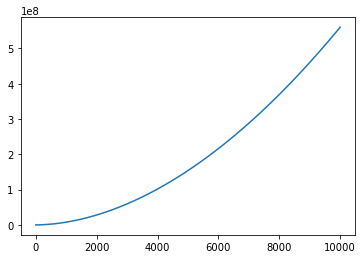

In [545]:
plt.plot(dist)

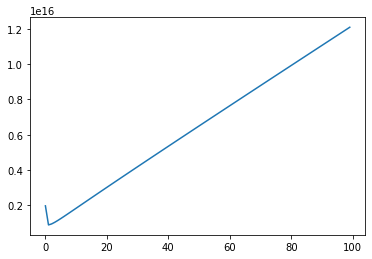

In [539]:
plt.plot(distVI)